## Note

1. Choose a proper Classifier  
2. Multiple-scale Windows
3. Optimize parameters

## Import Libraries

In [288]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
import pickle
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Functions for Extracting Features

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)            
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Functions for 'Single Image Test'

In [3]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Step 1 : Feature Extraction

### 1-1. Searching and Reading files

In [4]:
def search(dirname, flist):    
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, flist)
            else:
                ext = os.path.splitext(full_filename)[-1]
                if ext == '.png':                     
                    flist.append(str(full_filename))        
    except PermissionError:
        pass    

In [82]:
cars = []
search("./samples/vehicles", cars)

notcars = []
search("./samples/non-vehicles", notcars)

print(len(cars), len(notcars))

8792 8968


### 1-2. Find the best parameters

In [282]:
cars = cars[:1000]
notcars = notcars[0:1000]
print(len(cars), len(notcars))

1000 1000


In [120]:
result = {}
result['config'] = []
result['result'] = []

# Parameters for HOG feature
#color_spaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
color_spaces = ['YCrCb']
orients = [i for i in range(8,13,2)]
pix_per_cells = [i for i in range(8,13,2)]
cell_per_blocks = [2]
hog_channels = [0]

# Parameters for additional features
spatial_sizes = [(16, 16), (24, 24), (32,32)]
hist_bins = [10, 12, 16]    # Number of histogram bins
spatial_feat = True         # Spatial features on
hist_feat = True            # Histogram features on
hog_feat = True             # HOG features on

In [121]:
time = 0

for color_space in color_spaces :
    for orient in orients :
        for pix_per_cell in pix_per_cells :
            for cell_per_block in cell_per_blocks :
                for hog_channel in hog_channels :
                    for spatial_size in spatial_sizes :
                        for h_bins in hist_bins :
                            car_features = extract_features(cars, color_space=color_space, 
                                                            spatial_size=spatial_size, hist_bins=h_bins, 
                                                            orient=orient, pix_per_cell=pix_per_cell, 
                                                            cell_per_block=cell_per_block, 
                                                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                            hist_feat=hist_feat, hog_feat=hog_feat)
                            notcar_features = extract_features(notcars, color_space=color_space, 
                                                               spatial_size=spatial_size, hist_bins=h_bins, 
                                                               orient=orient, pix_per_cell=pix_per_cell, 
                                                               cell_per_block=cell_per_block, 
                                                               hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                               hist_feat=hist_feat, hog_feat=hog_feat)
                            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                            
                            X_scaler = StandardScaler().fit(X)
                            scaled_X = X_scaler.transform(X)

                            # Define the labels vector
                            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

                            rand_state = np.random.randint(0, 100)
                            X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

                            #svc = SVC(kernel = 'poly')
                            svc = LinearSVC()                            
                            svc.fit(X_train, y_train)                            
                            #round(svc.score(X_test, y_test), 4))
                            config = [color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, h_bins]
                            result['config'].append(config)
                            accuracy = round(svc.score(X_test, y_test), 4)
                            result['result'].append(accuracy)
                            time += 1
                            print('Iter',time,' : ', config, ' -> ', 'acc. = ', accuracy)

                            #with open("tunning_result_RGB.p", mode='wb') as f:
                            #with open("tunning_result_HSV.p", mode='wb') as f:
                            #with open("tunning_result_LUV.p", mode='wb') as f:
                            #with open("tunning_result_HLS.p", mode='wb') as f:
                            #with open("tunning_result_YUV.p", mode='wb') as f:
                            with open("tunning_result_YCrCb.p", mode='wb') as f:
                                pickle.dump(result, f)
print(' >> .. Done ..')

Iter 1  :  ['YCrCb', 8, 8, 2, 0, (16, 16), 10]  ->  acc. =  0.9975
Iter 2  :  ['YCrCb', 8, 8, 2, 0, (16, 16), 12]  ->  acc. =  0.9962
Iter 3  :  ['YCrCb', 8, 8, 2, 0, (16, 16), 16]  ->  acc. =  0.9938
Iter 4  :  ['YCrCb', 8, 8, 2, 0, (24, 24), 10]  ->  acc. =  0.9975
Iter 5  :  ['YCrCb', 8, 8, 2, 0, (24, 24), 12]  ->  acc. =  0.9925
Iter 6  :  ['YCrCb', 8, 8, 2, 0, (24, 24), 16]  ->  acc. =  0.9975
Iter 7  :  ['YCrCb', 8, 8, 2, 0, (32, 32), 10]  ->  acc. =  0.9912
Iter 8  :  ['YCrCb', 8, 8, 2, 0, (32, 32), 12]  ->  acc. =  0.9925
Iter 9  :  ['YCrCb', 8, 8, 2, 0, (32, 32), 16]  ->  acc. =  0.995
Iter 10  :  ['YCrCb', 8, 10, 2, 0, (16, 16), 10]  ->  acc. =  0.9938
Iter 11  :  ['YCrCb', 8, 10, 2, 0, (16, 16), 12]  ->  acc. =  0.9925
Iter 12  :  ['YCrCb', 8, 10, 2, 0, (16, 16), 16]  ->  acc. =  0.9962
Iter 13  :  ['YCrCb', 8, 10, 2, 0, (24, 24), 10]  ->  acc. =  0.9938
Iter 14  :  ['YCrCb', 8, 10, 2, 0, (24, 24), 12]  ->  acc. =  0.995
Iter 15  :  ['YCrCb', 8, 10, 2, 0, (24, 24), 16]  ->  

## Step 2 : Training Classifiers using the best parameters

In [79]:
color_space = 'YCrCb'
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

(64, 64)


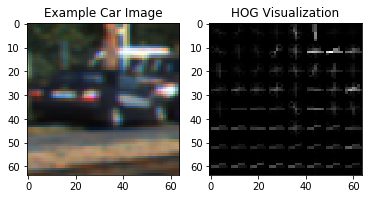

In [80]:
load = cars[5472]
hog_img = mpimg.imread(load)
hog_test  = cv2.cvtColor(hog_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
print(hog_test.shape)

features, hog_image = get_hog_features(hog_test, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(hog_img)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
#plt.savefig('./figures/hog_car.jpg')

(64, 64)


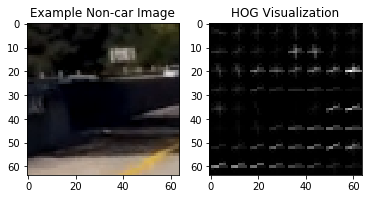

In [81]:
load = notcars[642]
hog_img = mpimg.imread(load)
hog_test  = cv2.cvtColor(hog_img, cv2.COLOR_RGB2YCrCb)[:,:,0]
print(hog_test.shape)

features, hog_image = get_hog_features(hog_test, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(hog_img)
plt.title('Example Non-car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
#plt.savefig('./figures/hog_notcar.jpg')

### 2-1. Training Linear SVM

In [207]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

color_space = 'YCrCb'
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                            
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC(loss='hinge')
svc.fit(X_train, y_train)

t=time.time()
accuracy = round(svc.score(X_test, y_test), 4)
t2 = time.time()
print(' >>',round(t2-t, 5), 'sec to predict')
print(' >> Test Accuracy is', accuracy)
print(' >> .. Done ..')

 >> 0.00643 sec to predict
 >> Test Accuracy is 0.9848
 >> .. Done ..


In [84]:
dump_data     = {}
dump_data["svc"] = svc
dump_data["scaler"] = X_scaler
dump_data["orient"] = orient
dump_data["pix_per_cell"]   = pix_per_cell   
dump_data["cell_per_block"] = cell_per_block
dump_data["spatial_size"]   = spatial_size   
dump_data["hist_bins"]      = hist_bins   

with open("svc_pickle_linear.p", mode='wb') as f:
    pickle.dump(dump_data, f)

### 2-2. Training SVM with kernel='poly'

In [208]:
car_features = extract_features(cars, color_space=color_space, 
                                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                                    orient=orient, pix_per_cell=pix_per_cell, 
                                                    cell_per_block=cell_per_block, 
                                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                    hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                                       orient=orient, pix_per_cell=pix_per_cell, 
                                                       cell_per_block=cell_per_block, 
                                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                       hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                            
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = SVC(kernel = 'poly')
svc.fit(X_train, y_train)

t=time.time()
accuracy = round(svc.score(X_test, y_test), 4)
t2 = time.time()
print(' >>',round(t2-t, 5), 'sec to predict')
print(' >> Test Accuracy is', accuracy)
print(' >> .. Done ..')

 >> 65.454 sec to predict
 >> Test Accuracy is 0.9924
 >> .. Done ..


In [34]:
dump_data     = {}
dump_data["svc"] = svc
dump_data["scaler"] = X_scaler
dump_data["orient"] = orient
dump_data["pix_per_cell"]   = pix_per_cell   
dump_data["cell_per_block"] = cell_per_block
dump_data["spatial_size"]   = spatial_size   
dump_data["hist_bins"]      = hist_bins   

with open("svc_pickle_poly.p", mode='wb') as f:
    pickle.dump(dump_data, f)

### 2-3. Training Decision Trees

In [209]:
car_features = extract_features(cars, color_space=color_space, 
                                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                                    orient=orient, pix_per_cell=pix_per_cell, 
                                                    cell_per_block=cell_per_block, 
                                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                    hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                                       orient=orient, pix_per_cell=pix_per_cell, 
                                                       cell_per_block=cell_per_block, 
                                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                                       hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                            
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

t=time.time()
accuracy = round(clf.score(X_test, y_test), 4)
t2 = time.time()
print(' >>',round(t2-t, 5), 'sec to predict')
print(' >> Test Accuracy is', accuracy)
print(' >> .. Done ..')

 >> 0.00997 sec to predict
 >> Test Accuracy is 0.9398
 >> .. Done ..


In [26]:
dump_data     = {}
dump_data["svc"] = svc
dump_data["scaler"] = X_scaler
dump_data["orient"] = orient
dump_data["pix_per_cell"]   = pix_per_cell   
dump_data["cell_per_block"] = cell_per_block
dump_data["spatial_size"]   = spatial_size   
dump_data["hist_bins"]      = hist_bins   

with open("svc_pickle_dt.p", mode='wb') as f:
    pickle.dump(dump_data, f)

## Test : Single Image Test

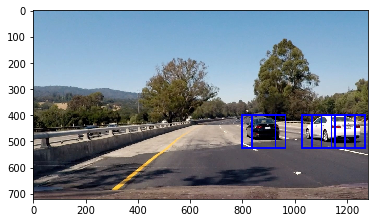

In [285]:
color_space = 'YCrCb'
hog_channel = 0
spatial_feat = True
hist_feat = True
hog_feat = True

#dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
dist_pickle = pickle.load( open("svc_pickle_linear.p", "rb" ) )
#dist_pickle = pickle.load( open("svc_pickle_dt.p", "rb" ) )

svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
win_size = 128

image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
y_start_stop = [np.int(image.shape[0]*0.5), image.shape[0]]

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(win_size, win_size), xy_overlap=(0.7, 0.7))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)

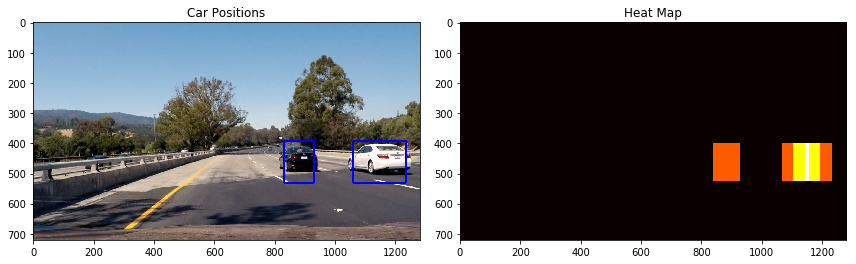

In [286]:
box_list = hot_windows

# Read in image similar to one shown above 
# image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(draw_image, labels)

fig = plt.figure(figsize=(12, 4.5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Step 3 : Build a Pipeline

### 3-1. Hog Sub-sampling Window Search

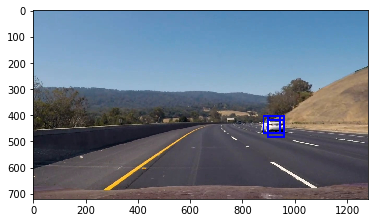

In [287]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, draw=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255 ## The classifier was trained using .png files
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    y_ch = ctrans_tosearch[:,:,0]
    
    # Define blocks and steps as above
    nxblocks = (y_ch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (y_ch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog_feat = get_hog_features(y_ch, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog_feat[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()             

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))            
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            X_scaler.transform(np.hstack((spatial_features.reshape(1, -1), hist_features.reshape(1, -1), hog_features.reshape(1, -1))))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            prob = svc.decision_function(test_features)
            
            if prob > 1.0 :            
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #print(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    
    if draw == True :
        return draw_img, box_list
    else :
        return box_list
    
dist_pickle = pickle.load( open("svc_pickle_linear.p", "rb" ) )

svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
ystart = np.int(image.shape[0]*0.56)
ystop  = np.int(image.shape[0]*0.95)
scale = 1.0

#image = mpimg.imread('./test_images/test4.jpg')
image = mpimg.imread('./test_images/26.jpg')
out_img, b_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, True)

plt.imshow(out_img)

### 3-2. Handling Multiple Detection
1) Make 'heatmap'  
2) Thresholding 'heatmap'  
3) Bounding the positives using label()

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    offset = 5
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y        
        bbox = ((np.min(nonzerox)-offset, np.min(nonzeroy)-offset), (np.max(nonzerox)+offset, np.max(nonzeroy)+offset))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

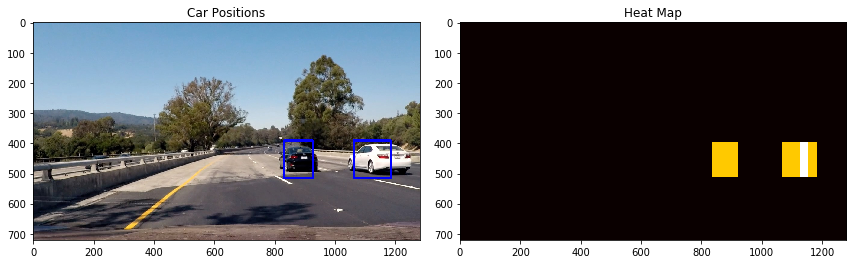

In [10]:
box_list = b_list

# Read in image similar to one shown above 
# image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure(figsize=(12, 4.5))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

### 3-3. Final Pipeline

In [280]:
def process_image (image) :
    global buffer
    
    dist_pickle = pickle.load( open("svc_pickle_linear.p", "rb" ) )    

    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    ystart = np.int(image.shape[0]*0.56)
    ystop  = np.int(image.shape[0]*0.95)
    
    scales = [0.8, 1.0, 1.2, 1.8]    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for scale in scales :
        boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat = add_heat(heat, boxes)
    
    heat = apply_threshold(heat, 1)  # Apply threshold to help remove false positives
        
    buffer.append(heat)
    mean_heatmap = np.mean(buffer, axis=0)
    mean_heatmap[mean_heatmap < 0.4] = 0 # Remove false positives appeared in very short time

    heatmap = np.clip(mean_heatmap, 0, 255) # Visualize the heatmap when displaying
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

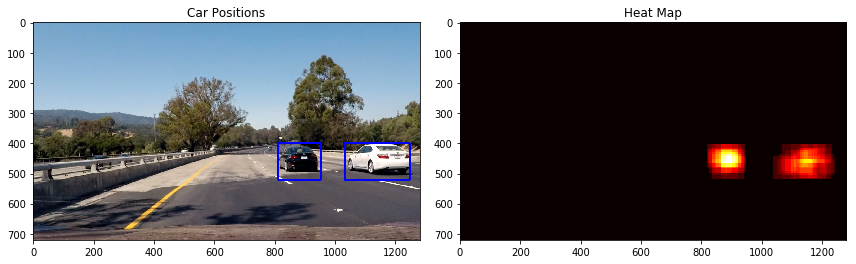

In [289]:
def process_image_test (image) :
    global buffer
    
    dist_pickle = pickle.load( open("svc_pickle_linear.p", "rb" ) )
    
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    ystart = np.int(image.shape[0]*0.56)
    ystop  = np.int(image.shape[0]*0.95)
    
    scales = [0.8, 1.0, 1.2, 1.8]    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for scale in scales :
        boxes = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat = add_heat(heat, boxes)
    
    heat = apply_threshold(heat, 1)  # Apply threshold to help remove false positives
        
    buffer.append(heat)
    mean_heatmap = np.mean(buffer, axis=0)
    mean_heatmap[mean_heatmap < 0.6] = 0

    heatmap = np.clip(mean_heatmap, 0, 255) # Visualize the heatmap when displaying
    # Find final boxes from heatmap using label function
    labels = label(heatmap)    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    #return draw_img, heatmap
    return draw_img, heatmap, labels[0]
    

from collections import deque
buffer = deque(maxlen=6)

test_image = mpimg.imread('./test_images/test4.jpg')
result_img, heatmap, label_map = process_image_test (test_image)

fig = plt.figure(figsize=(12, 4.5))
plt.subplot(121)
plt.imshow(result_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()   
plt.savefig('./figures/output.jpg')

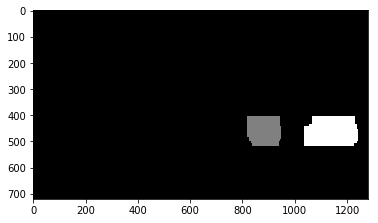

In [290]:
plt.imshow(label_map, cmap='gray')
plt.savefig('./figures/label_map.jpg')

In [277]:
from collections import deque
buffer = deque(maxlen=6)

video_in = "./project_video.mp4"
video_out = './result_project_video.mp4'

In [278]:
clip1 = VideoFileClip(video_in)
challenge_clip = clip1.fl_image(process_image2) #NOTE: this function expects color images!!
%time challenge_clip.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video ./result_project_video_remove_outlier.mp4
[MoviePy] Writing video ./result_project_video_remove_outlier.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:01<34:27,  1.64s/it]


  0%|          | 2/1261 [00:03<34:19,  1.64s/it]


  0%|          | 3/1261 [00:04<34:09,  1.63s/it]


  0%|          | 4/1261 [00:06<34:10,  1.63s/it]


  0%|          | 5/1261 [00:08<34:01,  1.63s/it]


  0%|          | 6/1261 [00:09<33:55,  1.62s/it]


  1%|          | 7/1261 [00:11<33:56,  1.62s/it]


  1%|          | 8/1261 [00:12<33:42,  1.61s/it]


  1%|          | 9/1261 [00:14<33:40,  1.61s/it]


  1%|          | 10/1261 [00:16<33:44,  1.62s/it]


  1%|          | 11/1261 [00:17<33:34,  1.61s/it]


  1%|          | 12/1261 [00:19<33:31,  1.61s/it]


  1%|          | 13/1261 [00:21<33:38,  1.62s/it]


  1%|          | 14/1261 [00:22<33:42,  1.62s/it]


  1%|          | 15/1261 [00:24<33:47,  1.63s/it]


  1%|▏         | 16/1261 [00:25<33:46,  1.63s/it]


  1%|▏         | 17/1261 [00:27<33:35,  1.62s/it]


  1%|▏         | 18/1261 [00:29<33:38,  1.62s/it]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: ./result_project_video_remove_outlier.mp4 

CPU times: user 38min 5s, sys: 2.04 s, total: 38min 7s
Wall time: 34min 26s


In [279]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(video_out))